# k-Nearest Neighbors

#

In [3]:
from typing import List
from collections import Counter

def raw_majority_votes(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_votes(["a", "b", "c", "b"]) == "b"

In [5]:
def majority_votes(labels: List[str]) -> str:
    """
    Assumes that labels are ordered from nearest to farthest.
    Reducing k until we find a unique winner.
    """
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count for count in vote_counts.values() if count == winner_count])
    if num_winners == 1:
        return winner   # unique winner, so return it
    else: 
        return majority_votes(labels[:-1])  # try again withouyt the farthest

# Tie, so look at first 4, then "b".
assert majority_votes(["a", "b", "c", "b", "a"]) == "b"

In [8]:
from typing import NamedTuple, List

Vector = List[float]

def distance(v1: Vector, v2: Vector) -> float:
    return sum((x1 - x2)**2 for x1, x2 in zip(v1, v2))**0.5

class LabeledPoint(NamedTuple):
    point: Vector
    label: str
    
def knn_classify(k: int, labeled_points: List[LabeledPoint], new_point: Vector) -> str:
    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points, key=lambda lp: distance(lp.point, new_point))
    
    # Find the labels for the k closest.
    k_nearest_labels = [lp.label for lp in by_distance[:k]]
    
    # And let them vote.
    return majority_votes(k_nearest_labels)

#

## Example: The Iris Dataset

In [9]:
import requests

data = requests.get(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
)

with open("iris.dat", "w") as f:
    f.write(data.text)

In [25]:
# ## DEPRECATED ###

# from typing import Dict
# import csv
# from collections import defaultdict

# def parse_iris_row(row: List[str]) -> LabeledPoint:
#     """
#     Parses a row from the Iris dataset.
#     sepal_length, sepal_width, petal_length, petal_wdith, class
#     """

#     measurements = [float(value) for value in row[:4]]
#     # class is e.g. ("Iris-virginica"); we just want "virginica".
#     label = row[-1].split("-")[-1].strip()
    
#     return LabeledPoint(measurements, label)


# with open("iris.dat") as f:
#     reader = csv.reader(f)
#     iris_data = [parse_iris_row(row) for row in reader]
    
#     # We'll also group just the points by species/label so we can plot them.
#     points_by_species: Dict[str, List[Vector]] = defaultdict(list)
#     for iris in iris_data:
#         points_by_species[iris.label].append(iris.point)

In [28]:
from typing import List, NamedTuple, Optional
import csv
from collections import defaultdict

class LabeledPoint(NamedTuple):
    point: List[float]
    label: str
    
def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    Parses a row from the Iris dataset.
    Row format: sepal_length, sepal_width, petal_length, petal_wdith, class
    """
    
    try:
        if len(row) != 5:
            # Skip rows that don't have exactly 5 elements.
            return None

        measurements = [float(value) for value in row[:4]]
        # class is e.g. ("Iris-virginica"); we just want "virginica".
        label = row[-1].split("-")[-1].strip()
        
        return LabeledPoint(measurements, label)
    
    except Exception as e:
        return None

# Path to the iris.dat file.
file_path = "./iris.dat"

try:
    with open(file_path, "r") as f:
        reader = csv.reader(f)
        iris_data = [parse_iris_row(row) for row in reader if parse_iris_row(row) is not None]

    points_by_species = defaultdict(list)
    for iris in iris_data:
        points_by_species[iris.label].append(iris.point)
        
except FileNotFoundError:
    print("File not found. Please check the file path.")
except Exception as e:
    print(f"An error occured: {e}")
    
# Number of entries and species names.
print(f"Total number of entries: {len(iris_data)}")
print(f"Species in the dataset: {list(points_by_species.keys())}")

Total number of entries: 150
Species in the dataset: ['setosa', 'versicolor', 'virginica']


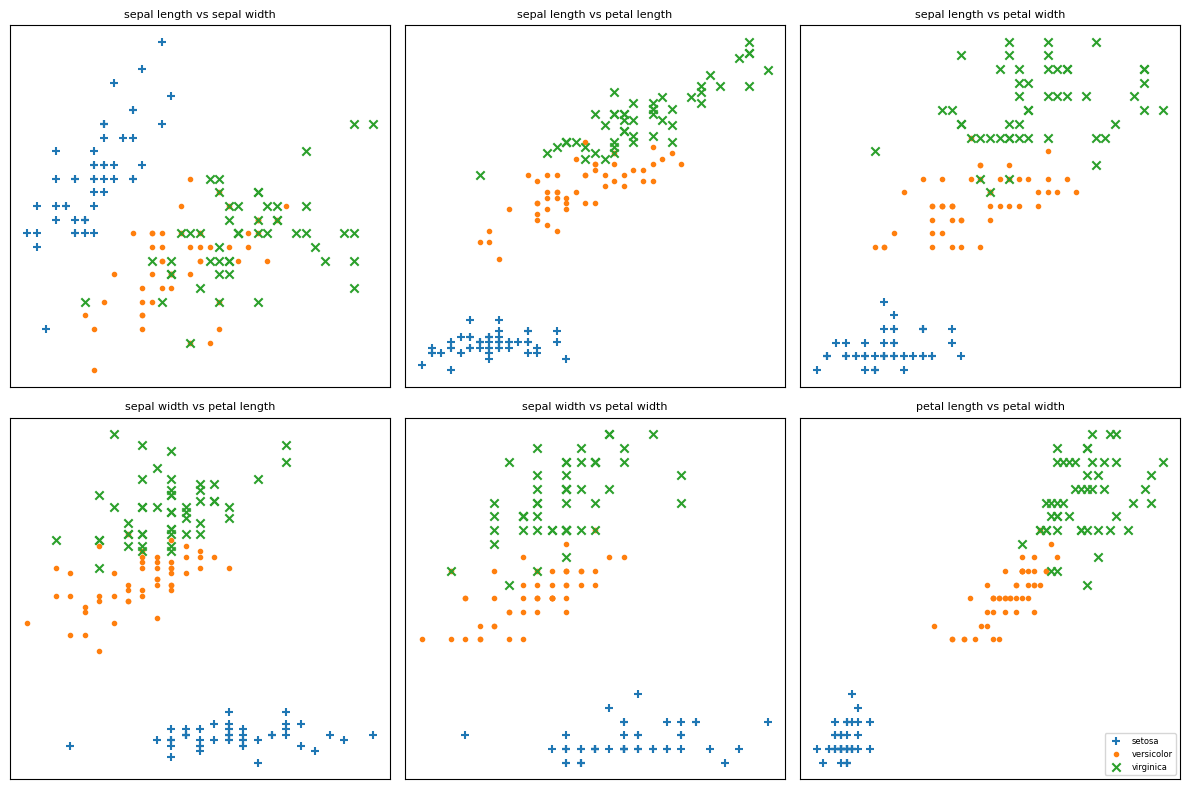

In [38]:
import matplotlib.pyplot as plt

metrics = ["sepal length", "sepal width", "petal length", "petal width"]
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ["+", ".", "x"]   # We have 3 classes, so 3 markers.

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row, col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row, col].scatter(xs, ys, marker=mark, label=species)

ax[-1, -1].legend(loc="lower right", prop={"size": 6})
plt.tight_layout()
plt.show()

In [39]:
import random
from typing import Tuple, List, Any

def split_data(data: List[Any], proportion: float) -> Tuple[List[Any], List[Any]]:
    """
    Splits the data into a training set and a test set by the given proportion
    :param data: The complete dataset.
    :param proportion: The proportion of the training set size.
    :return: A tuple containing the training set and the test set.
    """

    data = data[:]  # Make a shallow copy of the data
    random.shuffle(data)  # Shuffle the data
    cut = int(len(data) * proportion)  # Calculate the cut-off point for the split
    return data[:cut], data[cut:]

# Applying the custom split_data function.
random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)

# Assertions to check the split sizes.
assert len(iris_train) == int(0.7 * 150)
assert len(iris_test) == int(0.3 * 150)

In [41]:
from typing import Tuple, Dict

# Track how many times we see (predicted, actual).
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    
    if predicted == actual:
        num_correct += 1
        
        confusion_matrix[(predicted, actual)] += 1
        
pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16})


#

## The Curse of Dimensionality

In [42]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

In [49]:
def distances(v1: Vector, v2: Vector) -> float:
    """Calculates Euclidean distance between two points/vectors"""
    return sum((x1 - x2)**2 for x1, x2 in zip(v1, v2))**0.5

In [43]:
def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_pairs)]

In [44]:
import tqdm

dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)        # 10000 random pairs
    avg_distances.append(sum(distances) / 10000)    # track the average
    min_distances.append(min(distances))            # track the minimum

Curse of Dimensionality: 100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


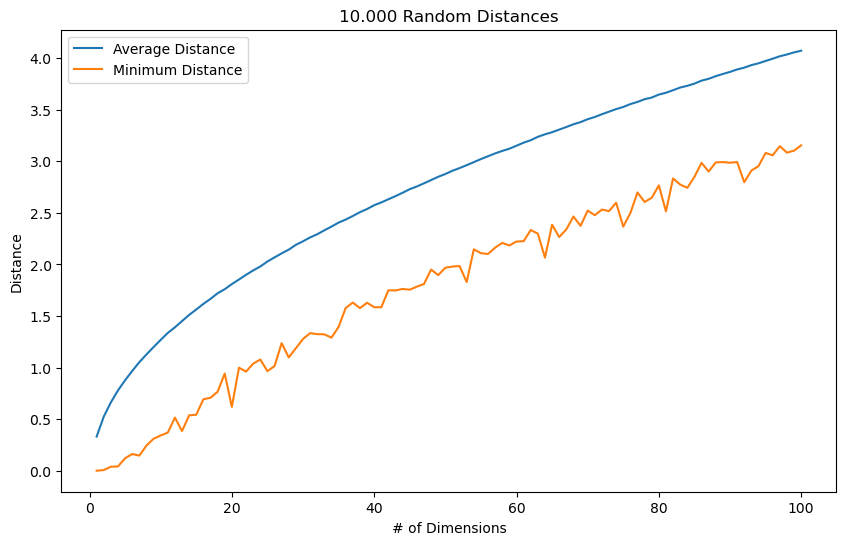

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(dimensions, avg_distances, label="Average Distance")
plt.plot(dimensions, min_distances, label="Minimum Distance")
plt.xlabel("# of Dimensions")
plt.ylabel("Distance")
plt.title("10.000 Random Distances")
plt.legend()
plt.show()

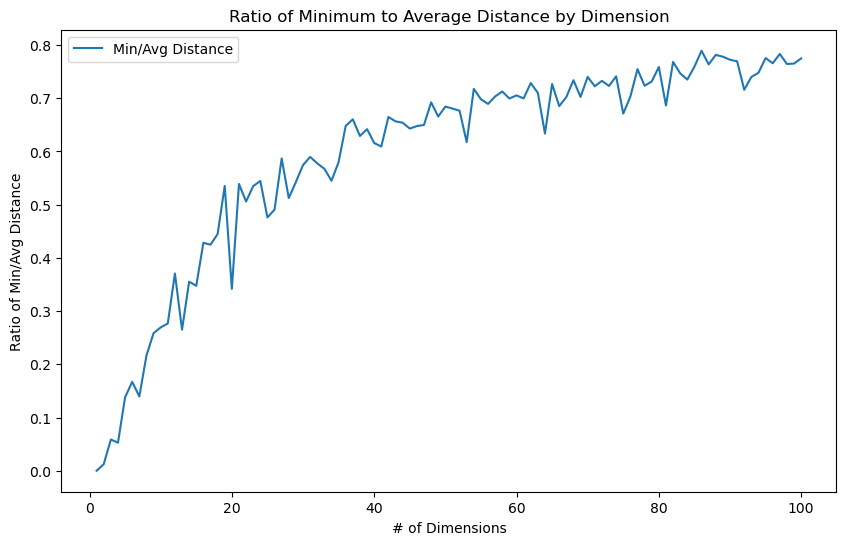

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(dimensions, [min_distances / avg_distances if avg_distances else 0 for min_distances, avg_distances in zip(min_distances, avg_distances)],
        label="Min/Avg Distance")
plt.xlabel("# of Dimensions")
plt.ylabel("Ratio of Min/Avg Distance")
plt.title("Ratio of Minimum to Average Distance by Dimension")
plt.legend()
plt.show()

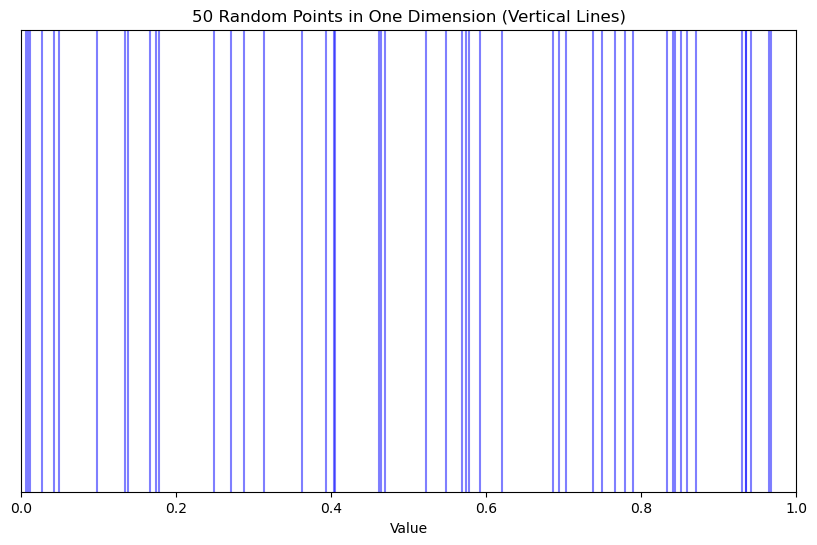

In [78]:
dimension = 1
num_points = 50

one_dim_points = [random_point(dimension) for _ in range(num_points)]

plt.figure(figsize=(10, 6))
for point in one_dim_points:
    plt.axvline(x=point[0], linestyle="-", color="blue", alpha=0.5)   # Drawing vertical line for each point
    
plt.xlabel("Value")
plt.title("50 Random Points in One Dimension (Vertical Lines)")
plt.yticks([])  # Hide y-axis as it's not relevant for 1D.
plt.show()

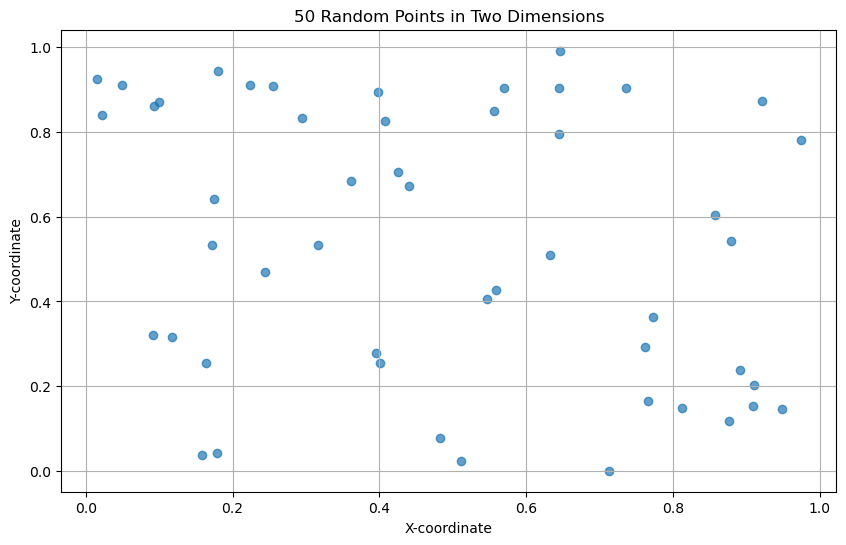

In [81]:
# 50 random points in two dimensions (unit square)
dimension = 2
num_points = 50

two_dim_points = [random_point(dimension) for _ in range(num_points)]

plt.figure(figsize=(10, 6))
plt.scatter([point[0] for point in two_dim_points], [point[1] for point in two_dim_points], alpha=0.7)
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.title("50 Random Points in Two Dimensions")
plt.grid(True)
plt.show()

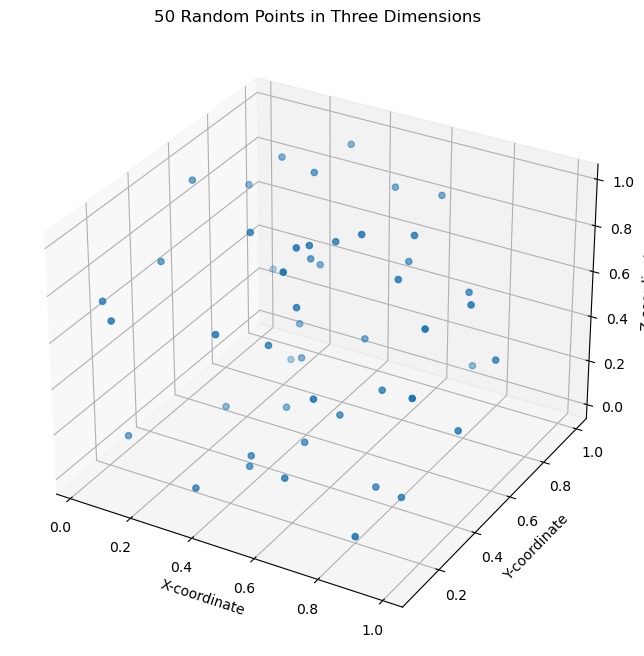

In [89]:
# 50 random points in three dimensions
from mpl_toolkits.mplot3d import Axes3D

dimension = 3
num_points = 50

three_dim_points = [random_point(dimension) for _ in range(num_points)]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter( [point[0] for point in three_dim_points],
            [point[1] for point in three_dim_points],
            [point[2] for point in three_dim_points])
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_zlabel("Z-coordinate")
ax.set_title("50 Random Points in Three Dimensions")
plt.show()